In [91]:
#!/hetghome/hetgsoft/anaconda3/bin/python3.9
#sed -i 's/\r//g' RK45_wo_tur_kmin.py
#chmod 777 RK45_wo_tur_kmin.py
from cProfile import label
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import math as m
import math
from scipy.optimize import fsolve
from scipy import linalg
import csv
import pandas as pd
import sys
import numpy as np
import os
from scipy.integrate import RK45
import time
acu = 1e-16
ts = 0.01
####################
theta = m.pi/2
ar = 0.7
omg = 0.01
omga = -omg
v=1
mu=1
t1=600
t0=0
##############################################################
vxp=m.sin(theta)*v
vxn=m.sin(theta)*(-v)
vz=m.cos(theta)*v
#################################################
def absq(x):
    return (1-abs(x)**2)**0.5
def comu(a,b):
    return np.matmul(a,b)-np.matmul(b,a)

Pz=np.array([[1,0],[0,-1]])
eps=10**-9
epsp=10**-8
rpp0=1/2*np.array([[1/2*(1+absq(eps)),1/2*eps],[1/2*eps,1/2*(1-absq(eps))]])
#print(rpp0)
#print(1/2*rpp0)
#sys.exit()
rpn0=1/2*np.array([[1/2*(1+absq(epsp)),1/2*epsp],[1/2*epsp,1/2*(1-absq(epsp))]])
rnp0=1/2*ar * np.array([[1/2*(1+absq(eps)),1/2*eps],[1/2*eps,1/2*(1-absq(eps))]])
rnn0=1/2*ar * np.array([[1/2*(1+absq(epsp)),1/2*epsp],[1/2*epsp,1/2*(1-absq(epsp))]])
y0=np.squeeze(np.array([rpp0,rpn0,rnp0,rnn0],dtype=complex).reshape((1,16)))
def tbif(t,y):
    #y[:4]=y.reshape()
    y=np.array([y[0:4].reshape((2,2)),y[4:8].reshape((2,2)),y[8:12].reshape((2,2)),y[12:16].reshape((2,2))])
    #print(y)
    #print(y[0])
    s = np.zeros((2,2),dtype=complex)
    dqdt=np.array([s,s,s,s])#+comu(15*Pz,y[0])
    dqdt[0]=(omg*comu(-Pz/2,y[0])+1.25*comu(y[1]-(y[3]),y[0]))+0.75*comu(y[0]-(y[2]),y[0])
    dqdt[1]=(omg*comu(-Pz/2,y[1])+1.25*comu(y[0]-(y[2]),y[1]))+0.75*comu(y[1]-(y[3]),y[1])
    dqdt[2]=(omga*comu(-Pz/2,y[2])+1.25*comu((y[1])-(y[3]),y[2]))+0.75*comu((y[0])-y[2],y[2])
    dqdt[3]=(omga*comu(-Pz/2,y[3])+1.25*comu((y[0])-(y[2]),y[3]))+0.75*comu((y[1])-y[3],y[3])
    """dqdt[0]=(omg*comu(-Pz/2,y[0])+1.25*comu(y[1]-np.matrix.conjugate(y[3]),y[0]))+0.75*comu(y[0]-np.matrix.conjugate(y[2]),y[0])
    dqdt[1]=(omg*comu(-Pz/2,y[1])+1.25*comu(y[0]-np.matrix.conjugate(y[2]),y[1]))+0.75*comu(y[1]-np.matrix.conjugate(y[3]),y[1])
    dqdt[2]=(omg*comu(-Pz/2,y[2])-1.25*comu(np.matrix.conjugate(y[1])-(y[3]),y[2]))-0.75*comu(np.matrix.conjugate(y[0])-y[2],y[2])
    dqdt[3]=(omg*comu(-Pz/2,y[3])-1.25*comu(np.matrix.conjugate(y[0])-(y[2]),y[3]))-0.75*comu(np.matrix.conjugate(y[1])-y[3],y[3])"""
    #print('------------------------------')
    #print(dqdt)
    rtn=np.squeeze(dqdt.reshape((1,16))/1j)
    #print(rtn)
    return rtn
"""def tbif(t,y):
    #dqdt=np.array([0+0j,0+0j,0+0j,0+0j])
    dqdt=y
    dqdt[0]=omg*dqdt[0]+0.75*0.5*mu*(absq(dqdt[1])*dqdt[0]-dqdt[1]*absq(dqdt[0]))+0.75*0.5*ar*mu*(absq(dqdt[3])*dqdt[0]-dqdt[3]*absq(dqdt[0]))
    dqdt[1]=omg*dqdt[1]+0.75*0.5*mu*(absq(dqdt[0])*dqdt[1]-dqdt[0]*absq(dqdt[1]))+0.75*0.5*ar*mu*(absq(dqdt[2])*dqdt[1]-dqdt[2]*absq(dqdt[1]))
    dqdt[2]=omga*dqdt[2]+0.75*0.5*ar*mu*(absq(dqdt[1])*dqdt[2]-dqdt[1]*absq(dqdt[2]))+0.75*0.5*ar*ar*mu*(absq(dqdt[3])*dqdt[2]-dqdt[3]*absq(dqdt[2]))
    dqdt[3]=omga*dqdt[3]+0.75*0.5*ar*mu*(absq(dqdt[0])*dqdt[3]-dqdt[0]*absq(dqdt[3]))+0.75*0.5*ar*ar*mu*(absq(dqdt[2])*dqdt[3]-dqdt[2]*absq(dqdt[3]))
    dqdt=1/(1j)*dqdt
    return dqdt"""
#print(tbif(0,y0))
#sys.exit()
if eps==epsp:
    fn='./f_fat_nonL_RK45_N1_omg_'+str(omg)+'_ar_'+str(ar)+'/'
else:
    fn='./f_asy_nonL_RK45_N1_omg_'+str(omg)+'_ar_'+str(ar)+'/'
if os.path.isdir(fn) == False:    
    os.mkdir(fn)
#Q0 = np.array([1.0+0j,1.0+0j,1.0+0j,1.0+0j])/2
#Q0 = np.array([10**-8+0j,10**-8+0j,10**-8+0j,10**-8+0j])/2
print(y0)
Sol = RK45(tbif,t0,y0,t1,max_step=ts, rtol=acu, atol=acu * 10**-3, vectorized=False, first_step=None)
T =  []
Qt = []
Qn = []
Qo = []
T.append(t0)
Qt.append(y0)
Qn.append(np.linalg.norm((rpp0)[0][0]))
Qo.append(np.linalg.norm((rpp0)[0][1]))
count_z  = 0
for k in range(10**12):
    Sol.step()
    if count_z%1000 ==0:
        T.append(Sol.t)
        Qn.append((np.linalg.norm(((Sol.y)[0]))))
        Qo.append((np.linalg.norm(((Sol.y)[1]))))
        Qt.append(((Sol.y)))
        print(Sol.t,'append')
    count_z +=1
    if Sol.status == 'finished':
        break
np.save(fn+'nonL_RK45_T',T)
np.save(fn+'nonL_RK45_Qt',Qt)
np.save(fn+'nonL_RK45_Qn',Qn)
np.save(fn+'nonL_RK45_Qo',Qo)


[5.00000000e-01+0.j 2.50000000e-10+0.j 2.50000000e-10+0.j
 0.00000000e+00+0.j 5.00000000e-01+0.j 2.50000000e-09+0.j
 2.50000000e-09+0.j 2.77555756e-17+0.j 3.50000000e-01+0.j
 1.75000000e-10+0.j 1.75000000e-10+0.j 0.00000000e+00+0.j
 3.50000000e-01+0.j 1.75000000e-09+0.j 1.75000000e-09+0.j
 1.94289029e-17+0.j]
0.005231129486015505 append


/hetghome/jordan/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


10.005231129485846 append
20.005231129486344 append
30.005231129487907 append
40.005231129486624 append
50.005231129484635 append
60.005231129482645 append
70.00523112948493 append
80.00523112949004 append
90.00523112949516 append
100.00523112950027 append
110.00523112950539 append
120.0052311295105 append
130.00523112951277 append
140.00523112950367 append
150.00523112949458 append
160.00523112948548 append
170.00523112947639 append
180.0052311294673 append
190.0052311294582 append
200.0052311294491 append
210.00523112944 append
220.0052311294309 append
230.00523112942182 append
240.00523112941272 append
250.00523112940363 append
260.00523112939453 append
270.00523112938544 append
280.00523112937634 append
290.00523112936725 append
300.00523112935815 append
310.00523112934906 append
320.00523112933996 append
330.00523112933087 append
340.00523112932177 append
350.0052311293127 append
360.0052311293036 append
370.0052311292945 append
380.0052311292854 append
390.0052311292763 append
40

f_asy_nonL_RK45_N1_omg_0.01_ar_0.7
2024-03-20 22:31:49.140172


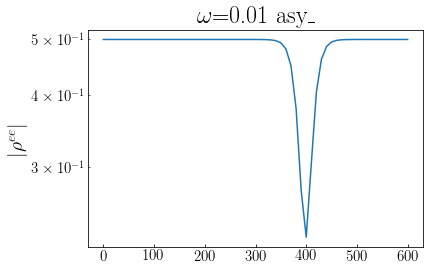

f_fat_nonL_RK45_N1_omg_0.01_ar_0.7
2024-03-20 21:22:16.384790


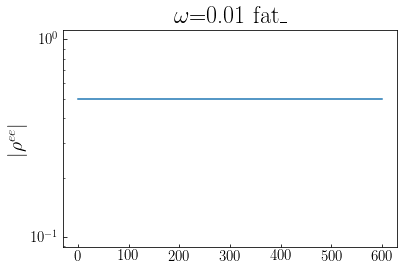

f_asy_nonL_RK45_N1_omg_-0.01_ar_0.7
2024-03-20 21:25:56.221789


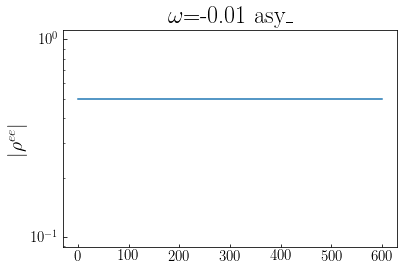

f_fat_nonL_RK45_N1_omg_-0.01_ar_0.7
2024-03-20 21:23:47.177790


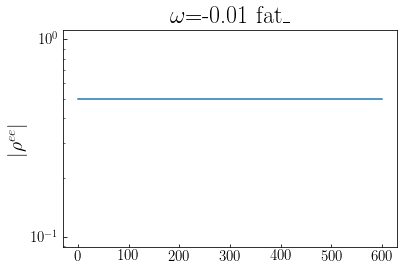

In [2]:
#!/hetghome/hetgsoft/anaconda3/bin/python3.9
%matplotlib inline
#%matplotlib widget
#%matplot plt
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math as m
import math
from scipy.fft import fft, fftfreq, fftshift
"""from scipy.optimize import fsolve
from scipy import linalg"""
import csv
import pandas as pd
import sys
import numpy as np
import os
from scipy.integrate import RK45
import time
import seaborn as sns
from os.path import exists
from matplotlib import rc
import datetime
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
rc('font',**{'family':'serif','serif':['Roman'],'size':20})
plt.rc('legend', fontsize=10) 
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)
rc('text', usetex=True)
#################################################################
#from configparser import ConfigParser

#########################################
path = os.getcwd()
#print(path)
for h in os.listdir(path):
    #print(h)
    if 'N1' not in h:
        #print('N1 conti')
        continue
    if 'RK45' not in h:
        #print('RK45 conti')
        continue
    if 'non' not in h:
        #print('non conti')
        continue
    if 'f_' not in h:
        #print('f_ conti')
        continue
    if 'old'  in h:
        #print('f_ conti')
        continue
    if '-0.7' in h:
        continue
    print(h)
    print(datetime.datetime.fromtimestamp(os.path.getmtime(path+'/'+h+'/nonL_RK45_T.npy')))
    ome=h[h.find('omg_')+4:h.find('_ar_')]
    T = np.load(path+'/'+h+'/nonL_RK45_T.npy')
    Qn = np.load(path+'/'+h+'/nonL_RK45_Qn.npy')
    Qo = np.load(path+'/'+h+'/nonL_RK45_Qo.npy')
    if 'fat' in h:
        fo='fat_'
    elif 'asy' in h:
        fo='asy_'
    else:
        fo=''
    plt.plot(T,Qn)
    #plt.xlim(-1,20)
    plt.title(r'$\omega$='+ome+' '+fo)
    plt.ylabel(r'$|\rho^{ee}|$')
    plt.yscale('log')
    plt.savefig(path+'/'+h+'/'+fo+'non_L.jpg')
    plt.show()
    plt.close('all')
    plt.plot(T,Qo)
    #plt.xlim(-1,20)
    plt.yscale('log')
    plt.title(r'$\omega$='+ome+' '+fo)
    plt.ylabel(r'$|\rho^{e\chi}|$')
    plt.savefig(path+'/'+h+'/'+fo+'non_L_Qo.jpg')
    #plt.show()
    plt.close('all')
    
    #sys.exit()

In [4]:
#plot differnt coponents of the 
#!/hetghome/hetgsoft/anaconda3/bin/python3.9
%matplotlib inline
#%matplotlib widget
#%matplot plt
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math as m
import math
from scipy.fft import fft, fftfreq, fftshift
"""from scipy.optimize import fsolve
from scipy import linalg"""
import csv
import pandas as pd
import sys
import numpy as np
import os
from scipy.integrate import RK45
import time
import seaborn as sns
from os.path import exists
from matplotlib import rc
import datetime
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
rc('font',**{'family':'serif','serif':['Roman'],'size':20})
plt.rc('legend', fontsize=10) 
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)
rc('text', usetex=True)
#################################################################
#from configparser import ConfigParser

#########################################
path = os.getcwd()
#print(path)
for h in os.listdir(path):
    #print(h)
    if 'N1' not in h:
        #print('N1 conti')
        continue
    if 'RK45' not in h:
        #print('RK45 conti')
        continue
    if 'non' not in h:
        #print('non conti')
        continue
    if 'f_' not in h:
        #print('f_ conti')
        continue
    if 'old'  in h:
        #print('f_ conti')
        continue
    if '-0.7' in h:
        continue
    if 'asy' not in h:
        continue
    print(h)
    print(datetime.datetime.fromtimestamp(os.path.getmtime(path+'/'+h+'/nonL_RK45_T.npy')))
    ome=h[h.find('omg_')+4:h.find('_ar_')]
    T = np.load(path+'/'+h+'/nonL_RK45_T.npy')
    Qn = np.load(path+'/'+h+'/nonL_RK45_Qn.npy')
    Qo = np.load(path+'/'+h+'/nonL_RK45_Qo.npy')
    if 'fat' in h:
        fo='fat_'
    elif 'asy' in h:
        fo='asy_'
    else:
        fo=''
    plt.plot(T,Qn)
    #plt.xlim(-1,20)
    plt.title(r'$\omega$='+ome+' '+fo)
    plt.ylabel(r'$|\rho^{ee}|$')
    plt.yscale('log')
    plt.savefig(path+'/'+h+'/'+fo+'non_L.jpg')
    plt.show()
    plt.close('all')
    plt.plot(T,Qo)
    #plt.xlim(-1,20)
    plt.yscale('log')
    plt.title(r'$\omega$='+ome+' '+fo)
    plt.ylabel(r'$|\rho^{e\chi}|$')
    plt.savefig(path+'/'+h+'/'+fo+'non_L_Qo.jpg')
    #plt.show()
    plt.close('all')
    
    #sys.exit()

[[1.-1.j  0.-1.j ]
 [0.+0.2j 1.-1.j ]]


array([[1.+1.j , 0.+1.j ],
       [0.-0.2j, 1.+1.j ]])